In [1]:
# import sys
# import os
# sys.path.append(os.path.abspath('../VAE'))  # Adds the directory of 'script/VAE' to Python path
# from utils import *

# os.chdir('../..')
# print(os.getcwd())

# data_path = './data/PAS Challenge HR Data.xlsx'  
# _, _, df_scaled, df = prepare_data(data_path)

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../CLIP')) 


from config import *
from encoder import *
from data import *
from augmentor import *
from describer import *
print("using device: ", device)
random_state = 333
import pandas as pd
import os

# import pkg_resources
# print(pkg_resources.get_distribution('python-calamine').version)



Random seed set to 333
using device:  cpu


In [3]:
import numpy as np
import pandas as pd
from tslearn.metrics import dtw, lcss
from joblib import Parallel, delayed
from tqdm import tqdm
import gc

def process_batch(i, df, sample_size=1000, by = 'dtw'):
    n_rows = len(df)
    series1 = df.iloc[i].values
    
    # Sample indices (excluding index i)
    available_indices = list(set(range(n_rows)) - {i})
    if len(available_indices) > sample_size:
        sampled_indices = np.random.choice(available_indices, sample_size, replace=False)
    else:
        sampled_indices = available_indices
    
    # Calculate distances for sampled indices
    distances = []
    for j in sampled_indices:
        series2 = df.iloc[j].values
        if by == 'dtw':
            dist = dtw(series1, series2)  # or use lcss if preferred
        elif by == 'lcss':
            dist = lcss(series1, series2)
        elif by == 'euclidean':
            dist = np.linalg.norm(series1 - series2)
        distances.append((j, dist))
    
    # Get top 3 furthest indices
    top_3_indices = sorted(distances, key=lambda x: x[1], reverse=True)[:3]
    top_indices = [idx for idx, _ in top_3_indices]
    
    # Free memory
    del series1, distances
    gc.collect()
    
    return i, top_indices

def find_furthest_neighbors(df, n_jobs=10, sample_size=1000, by = 'dtw'):
    n_rows = len(df)
    # Process all rows in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_batch)(i, df, sample_size, by) for i in tqdm(range(n_rows))
    )
    # Organize results into a dictionary
    furthest_neighbors = {i: top_3 for i, top_3 in results}
    
    return furthest_neighbors


/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
# -----------------Train Data-----------------
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions_parallel(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = text_gen_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# -----------------Test Data-----------------
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions_parallel(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = text_gen_input_column(df_test, config_dict['text_config'])
# df_test_org = df_test[df.columns]
# df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org['cl_event'], random_state=random_state) 


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.4s
[Parallel(n_jobs=9)]: Done 5138 tasks      | elapsed:    5.4s
[Parallel(n_jobs=9)]: Done 63704 tasks      | elapsed:   12.2s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   12.4s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  No Bradycardia events.  Moderate variability.  Very low amount of consecutive increases. 

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    1.8s
[Parallel(n_jobs=9)]: Done 61182 tasks      | elapsed:    6.5s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:    6.6s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.  No Bradycardia events.  High variability.  Low amount of consecutive increases. 


In [7]:
# df = df_train.loc[:, '1':'300'].copy()

# # Usage 
# if __name__ == '__main__':
#     for by in ['euclidean']:
#         # Find furthest neighbors
#         furthest3 = find_furthest_neighbors(df, n_jobs=10, sample_size=df.shape[0], by = by)
#         # save the furthest_neighbors
#         np.save('./results/train_'+by+'_furthest3_'+str(df.shape[0])+'.npy', furthest3)


In [8]:
df = df_test.loc[:, '1':'300'].copy()

# Usage 
if __name__ == '__main__':
    for by in ['euclidean']:
        # Find furthest neighbors
        furthest3 = find_furthest_neighbors(df, n_jobs=8, sample_size=df.shape[0], by = by)
        # save the furthest_neighbors
        np.save('./results/test_'+by+'_furthest3_'+str(df.shape[0])+'.npy', furthest3)


  0%|          | 0/61570 [00:00<?, ?it/s]/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSer

In [14]:
df_train.iloc[i].values

array([1007, 122170, 132, 132, 133, 133, 133, 133, 133, 133, 133, 133,
       133, 133, 134, 134, 134, 134, 134, 133, 133, 133, 133, 133, 133,
       133, 134, 134, 134, 134, 133, 133, 133, 133, 133, 152, 152, 133,
       134, 133, 152, 152, 133, 133, 132, 132, 133, 133, 133, 134, 134,
       134, 134, 134, 134, 133, 134, 134, 134, 134, 134, 134, 134, 134,
       134, 133, 134, 134, 134, 134, 134, 134, 133, 134, 133, 133, 133,
       133, 133, 133, 133, 133, 133, 133, 132, 132, 142, 151, 133, 132,
       132, 131, 130, 130, 131, 132, 132, 131, 131, 130, 131, 132, 132,
       132, 132, 132, 132, 132, 132, 132, 132, 131, 131, 132, 131, 132,
       132, 150, 150, 132, 132, 133, 133, 133, 133, 133, 133, 152, 142,
       133, 133, 133, 133, 133, 133, 133, 133, 133, 134, 133, 134, 134,
       134, 133, 134, 139, 131, 134, 134, 134, 134, 134, 134, 134, 134,
       134, 135, 134, 134, 134, 134, 134, 131, 134, 134, 134, 134, 134,
       134, 134, 134, 134, 134, 134, 134, 124, 123, 134, 134, 134

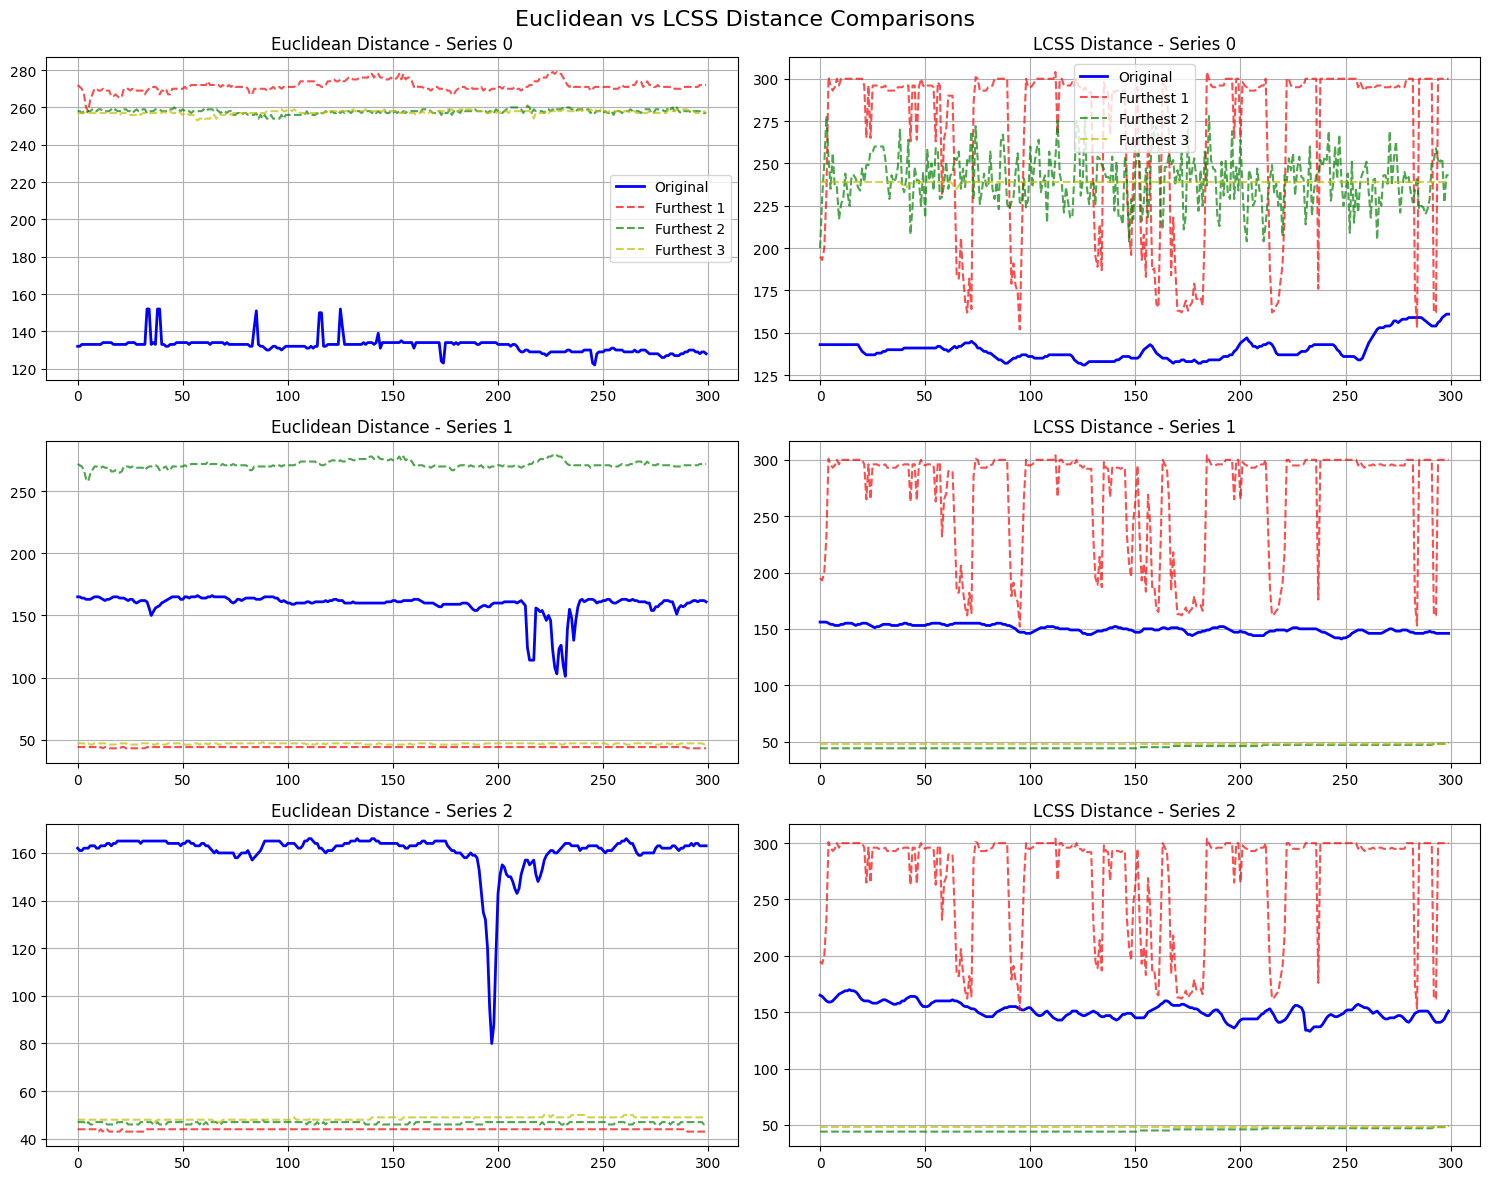

In [18]:

import matplotlib.pyplot as plt
# load the furthest_neighbors
euc_furthest3_train = np.load('./results/train_euclidean_furthest3_'+str(df_train.shape[0])+'.npy', allow_pickle=True)
euc_furthest3_test = np.load('./results/test_euclidean_furthest3_'+str(df_test.shape[0])+'.npy', allow_pickle=True)

# Create 3x2 subplot to take a look at negative samples
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Euclidean vs LCSS Distance Comparisons', fontsize=16)

for i in range(3):
    # Left column: Euclidean distance comparisons
    axes[i,0].plot(df_train.loc[i, '1':'300'].values, 'b-', label='Original', linewidth=2)
    axes[i,0].plot(df_train.loc[euc_furthest3_train.item()[i][0], '1':'300'].values, 'r--', alpha=0.7, label='Furthest 1')
    axes[i,0].plot(df_train.loc[euc_furthest3_train.item()[i][1], '1':'300'].values, 'g--', alpha=0.7, label='Furthest 2')
    axes[i,0].plot(df_train.loc[euc_furthest3_train.item()[i][2], '1':'300'].values, 'y--', alpha=0.7, label='Furthest 3')
    axes[i,0].set_title(f'Euclidean Distance - Series {i}')
    axes[i,0].grid(True)
    if i == 0:
        axes[i,0].legend()
    
    # Right column: LCSS distance comparisons
    axes[i,1].plot(df_test.loc[i, '1':'300'].values, 'b-', label='Original', linewidth=2)
    axes[i,1].plot(df_test.loc[euc_furthest3_test.item()[i][0], '1':'300'].values, 'r--', alpha=0.7, label='Furthest 1')
    axes[i,1].plot(df_test.loc[euc_furthest3_test.item()[i][1], '1':'300'].values, 'g--', alpha=0.7, label='Furthest 2')
    axes[i,1].plot(df_test.loc[euc_furthest3_test.item()[i][2], '1':'300'].values, 'y--', alpha=0.7, label='Furthest 3')
    axes[i,1].set_title(f'LCSS Distance - Series {i}')
    axes[i,1].grid(True)
    if i == 0:
        axes[i,1].legend()

plt.tight_layout()
plt.show()


# Convert to dataframe
data = []
furthest_dict = euc_furthest3_train.item()
for i in furthest_dict.keys():
    data.append({
        'euc_far_rowid1': euc_furthest3_train.item()[i][0],
        'euc_far_rowid2': euc_furthest3_train.item()[i][1],
        'euc_far_rowid3': euc_furthest3_train.item()[i][2]
    })
    
df_furthest3 = pd.DataFrame(data)
df_furthest3.to_csv('../../data/train_furthest3.csv', index=False)
data = []
furthest_dict = euc_furthest3_test.item()
for i in furthest_dict.keys():
    data.append({
        'euc_far_rowid1': euc_furthest3_test.item()[i][0],
        'euc_far_rowid2': euc_furthest3_test.item()[i][1],
        'euc_far_rowid3': euc_furthest3_test.item()[i][2]
    })
    
df_furthest3 = pd.DataFrame(data)
df_furthest3.to_csv('../../data/test_furthest3.csv', index=False)

